## Main Jupyter Notebooks for implementing the German Traffic Sign Classification CNN

### Read in Data

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import os
import matplotlib.pyplot as plt

In [59]:
# Gibt an, ob wir auf einer GPU oder CPU trainieren 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [60]:
dataset = ImageFolder("GTSRB\Final_Training\Images", transform=transforms.ToTensor())
loader = DataLoader(dataset, batch_size=64, shuffle=False)

mean = 0.
std = 0.
total_images_count = 0

for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images_count += batch_samples

mean /= total_images_count
std /= total_images_count

print(f"Mean: {mean}")
print(f"Std: {std}")


Mean: tensor([0.3433, 0.3151, 0.3253])
Std: tensor([0.1690, 0.1713, 0.1815])


In [61]:
transform = transforms.Compose([
    transforms.Resize((35, 35)),  
    transforms.ToTensor(),
    # TODO: Schauen ob 0.5 überall besser ist oder ob selbst berechnete werte besser 
    transforms.Normalize(mean.tolist(), std.tolist()) 
    #transforms.Normalize((0.5,), (0.5,))
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7489485..3.9978275].


Label: baustelle


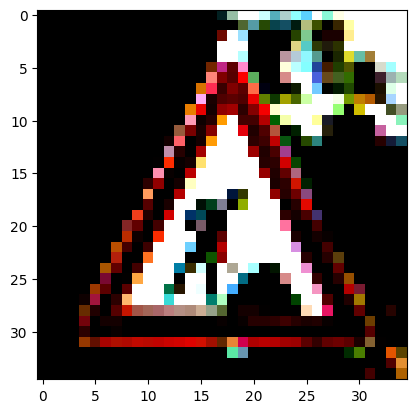

In [62]:
train_dataset = ImageFolder(root='GTSRB/Final_Training/Images', transform=transform)

test_dataset = ImageFolder(root='GTSRB/Final_Test/Images', transform=transform)

# Die Batchsize ist die Anzahl der Bilder, die auf einmal in das Netzwerk eingespeist werden. 
# Heißt es werden pro Trainingsschritt 64 Bilder durch das Netzwerk geschickt, dafür der Loss berechnet und dann für diesen Batch gemittelt, 
# anschließend werden die Parameter auf dem Durchschnittsgradienten aktualisiert.
batch_size = 64
test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
num_classes = 43
# --------- Testing ---------
img, label = test_dataset[3452]
label_string = test_dataset.classes[label]
print("Label:", label_string)
plt.imshow(img.permute(1, 2, 0))
#print(img)





### Create the Model

TODO: Über IMG Size sprechen (die meisten nutzen 32x32)

In [63]:

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=4, padding=1)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=4, padding=1)
        self.relu3 = nn.ReLU()

        self.conv_layer4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=4, padding=1)
        self.relu4 = nn.ReLU()

        self.conv_layer5 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=4, padding=1)
        self.relu5 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.dropout6 = nn.Dropout(p=0.3)
        
        self.fc6 = nn.Linear(128, 512) 
        self.relu6 = nn.ReLU()
        self.dropout7 = nn.Dropout(p=0.3)
        self.fc7 = nn.Linear(512, 256)
        self.relu7 = nn.ReLU()

        self.dropout8 = nn.Dropout(p=0.3)
        self.fc8 = nn.Linear(256, 128)
        self.relu8 = nn.ReLU()

        self.fc9 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)

        out = self.conv_layer2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)

        out = self.conv_layer3(out)
        out = self.relu3(out)

        out = self.conv_layer4(out)
        out = self.relu4(out)

        out = self.conv_layer5(out)
        out = self.relu5(out)
        out = self.max_pool5(out)

        out = out.reshape(out.size(0), -1)
        out = self.dropout6(out)
        out = self.fc6(out)
        out = self.relu6(out)

        out = self.dropout7(out)
        out = self.fc7(out)
        out = self.relu7(out)

        out = self.dropout8(out)
        out = self.fc8(out)
        out = self.relu8(out)

        out = self.fc9(out)

        return out

In [65]:
# Initialisierung des Modells
model = CNN(num_classes).to(device)
loss_func = nn.CrossEntropyLoss()

# Initiale Lernrate und Optimizer
lr = 0.005
weight_decay = 0.001
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

# ReduceLROnPlateau Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [42]:
num_epochs = 40
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Save model
torch.save(model.state_dict(), 'model/40_epochs_self_normalized.pth')

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16


KeyboardInterrupt: 

### Test model with accuracy print

Epoch 1/100
Training Loss: 3.7498
Training Accuracy: 6.33%
Test Accuracy: 6.64%


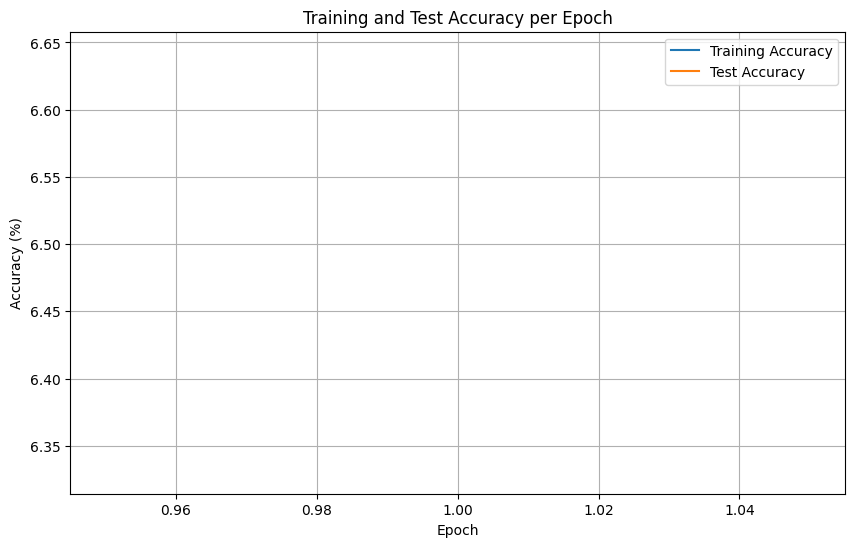

Epoch 2/100
Training Loss: 3.7172
Training Accuracy: 6.33%
Test Accuracy: 6.64%


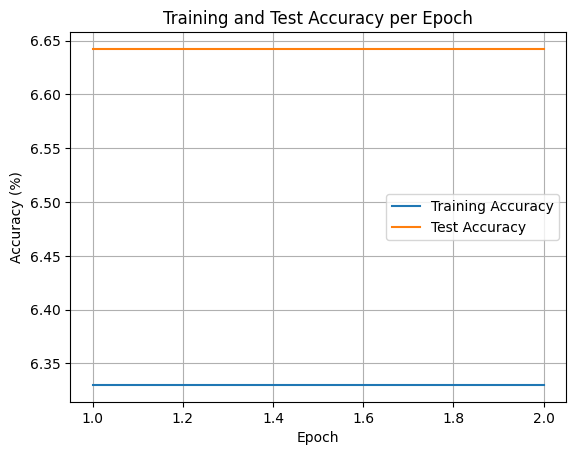

Epoch 3/100
Training Loss: 3.6852
Training Accuracy: 6.33%
Test Accuracy: 6.64%


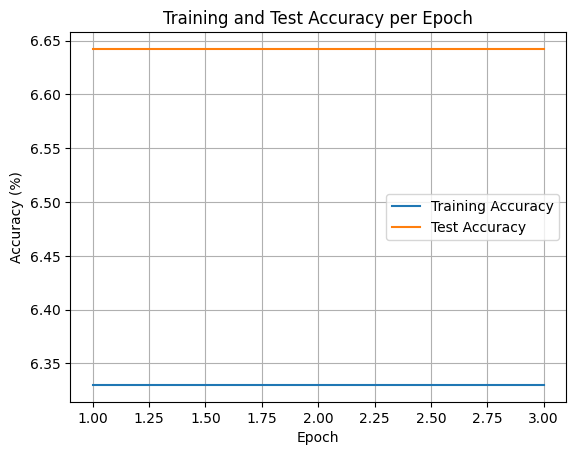

Epoch 4/100
Training Loss: 3.5926
Training Accuracy: 6.72%
Test Accuracy: 6.91%


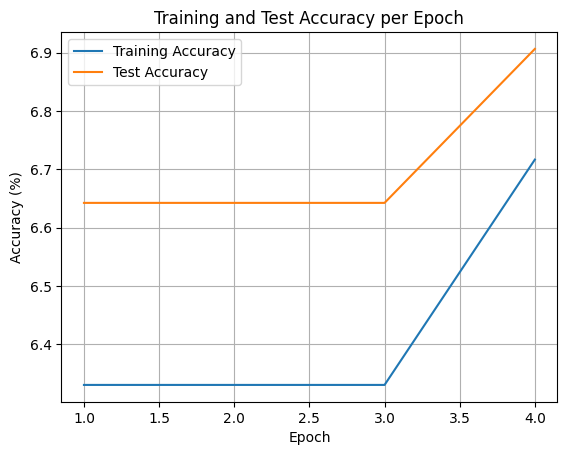

Epoch 5/100
Training Loss: 3.4861
Training Accuracy: 6.82%
Test Accuracy: 6.78%


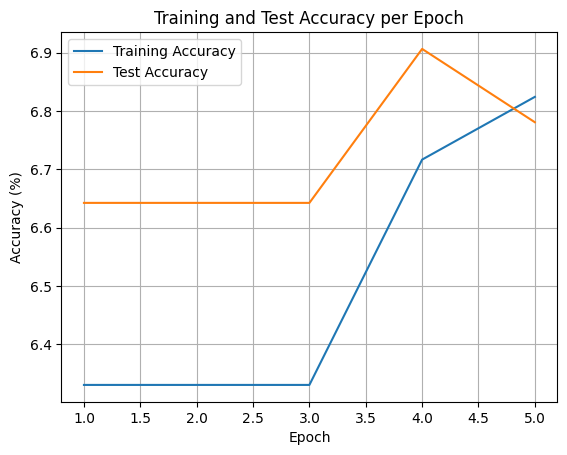

Epoch 6/100
Training Loss: 3.4743
Training Accuracy: 6.76%
Test Accuracy: 6.81%


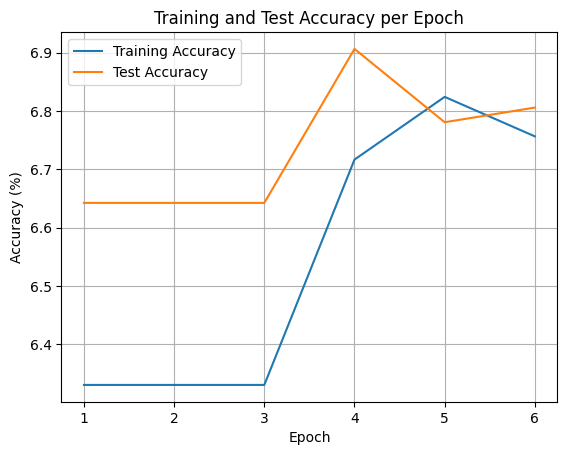

Epoch 7/100
Training Loss: 3.4621
Training Accuracy: 6.88%
Test Accuracy: 6.84%


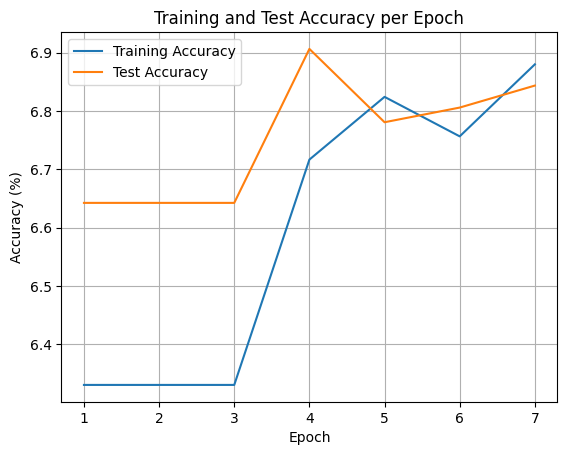

Epoch 8/100
Training Loss: 3.4320
Training Accuracy: 6.83%
Test Accuracy: 7.06%


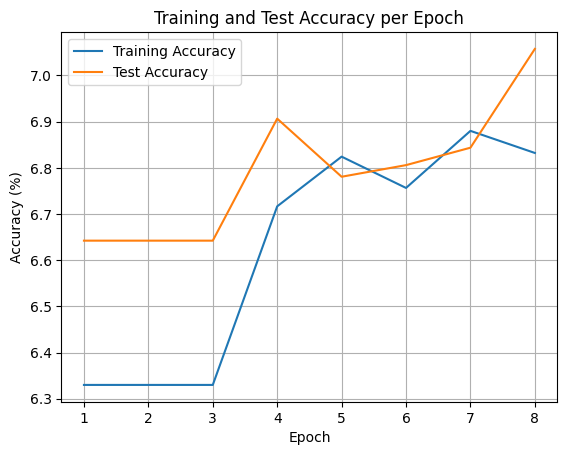

Epoch 9/100
Training Loss: 3.3857
Training Accuracy: 8.13%
Test Accuracy: 8.11%


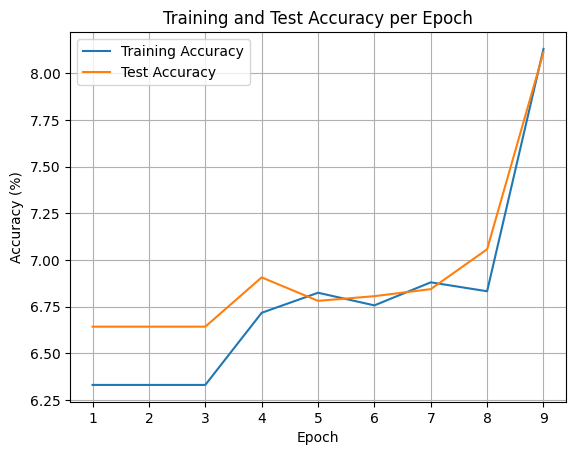

Epoch 10/100
Training Loss: 3.3303
Training Accuracy: 6.31%
Test Accuracy: 6.78%


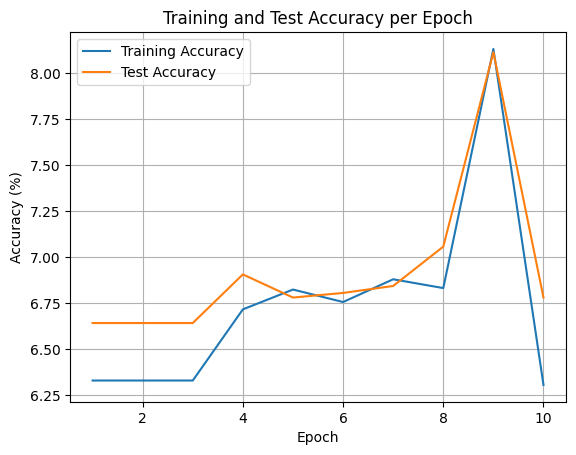

Epoch 11/100
Training Loss: 3.2487
Training Accuracy: 10.23%
Test Accuracy: 10.96%


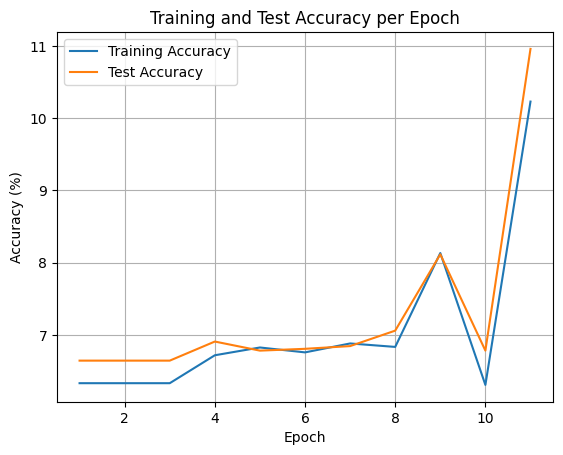

Epoch 12/100
Training Loss: 3.1856
Training Accuracy: 13.07%
Test Accuracy: 12.82%


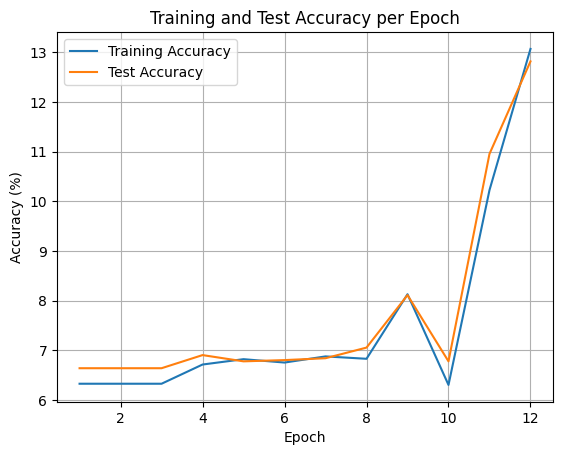

Epoch 13/100
Training Loss: 3.1327
Training Accuracy: 13.47%
Test Accuracy: 13.93%


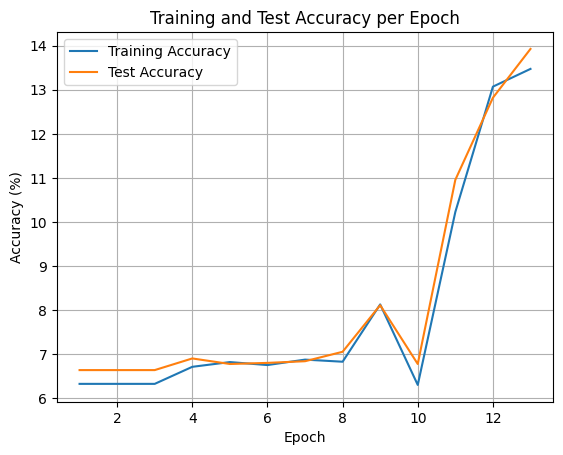

Epoch 14/100
Training Loss: 3.0904
Training Accuracy: 15.38%
Test Accuracy: 15.34%


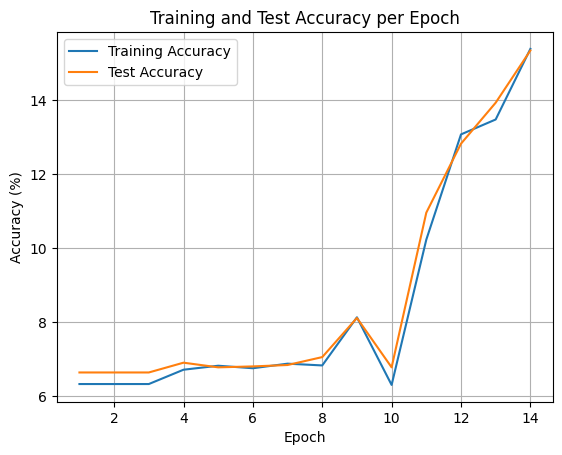

Epoch 15/100
Training Loss: 3.0534
Training Accuracy: 15.44%
Test Accuracy: 15.46%


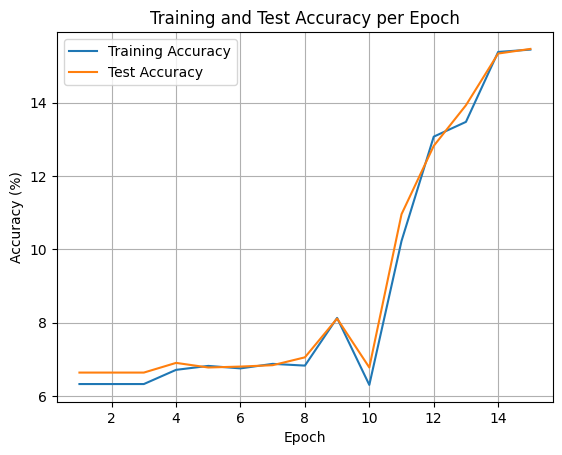

Epoch 16/100
Training Loss: 3.0143
Training Accuracy: 15.63%
Test Accuracy: 15.85%


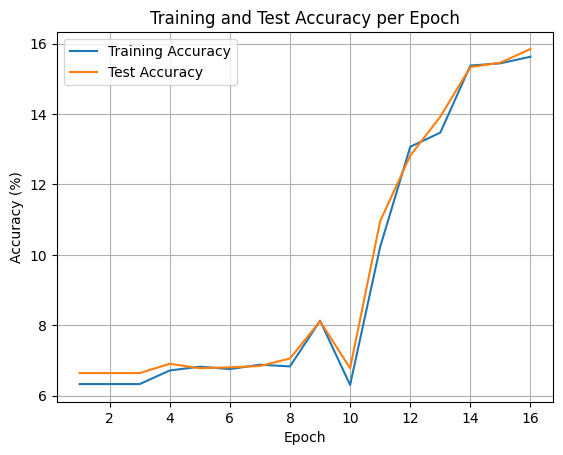

Epoch 17/100
Training Loss: 2.9768
Training Accuracy: 14.77%
Test Accuracy: 15.37%


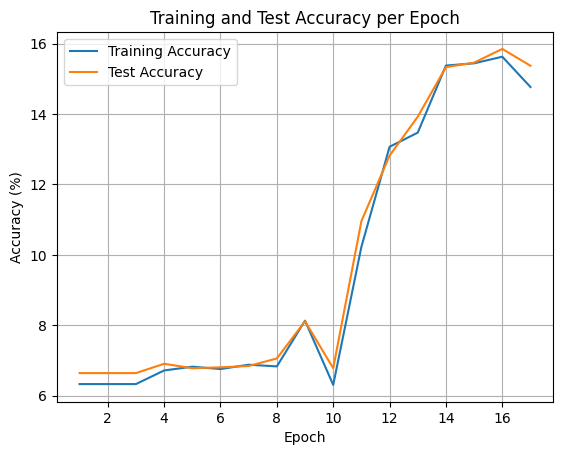

Epoch 18/100
Training Loss: 2.9328
Training Accuracy: 17.90%
Test Accuracy: 18.49%


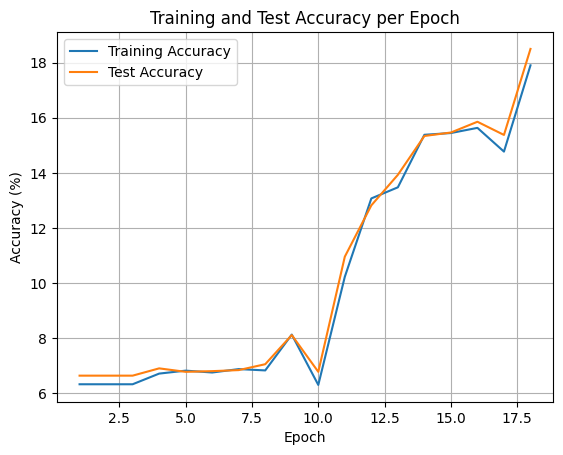

Epoch 19/100
Training Loss: 2.8997
Training Accuracy: 16.66%
Test Accuracy: 16.32%


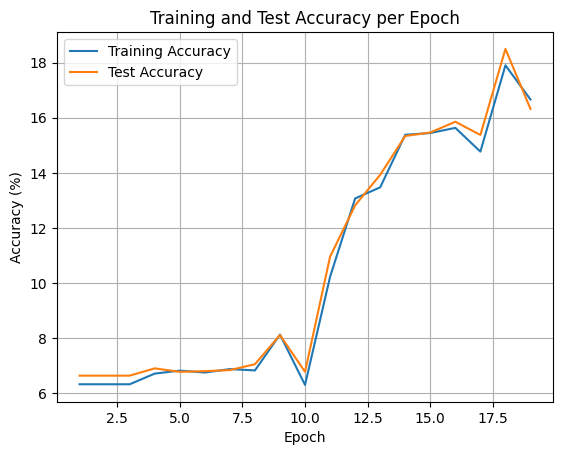

Epoch 20/100
Training Loss: 2.8672
Training Accuracy: 16.81%
Test Accuracy: 17.44%


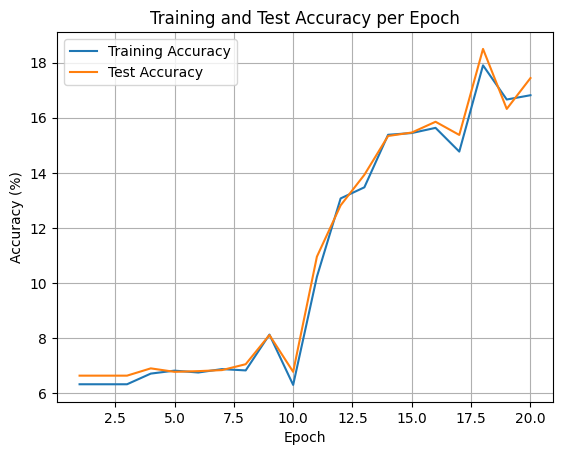

Epoch 21/100
Training Loss: 2.8304
Training Accuracy: 19.24%
Test Accuracy: 19.02%


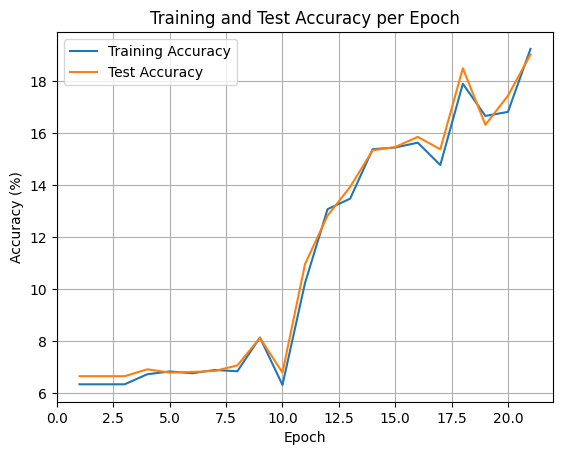

Epoch 22/100
Training Loss: 2.7900
Training Accuracy: 19.01%
Test Accuracy: 18.90%


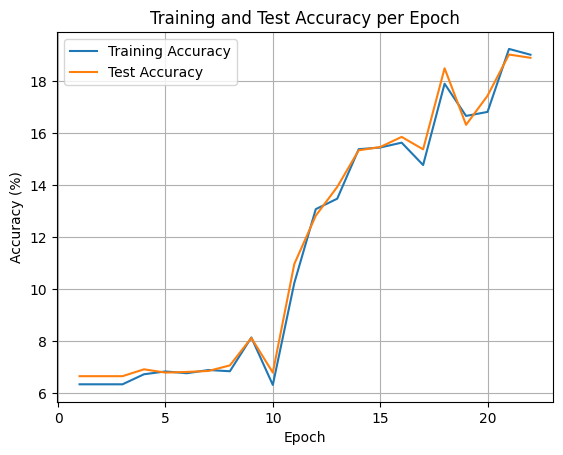

Epoch 23/100
Training Loss: 2.7317
Training Accuracy: 20.77%
Test Accuracy: 22.49%


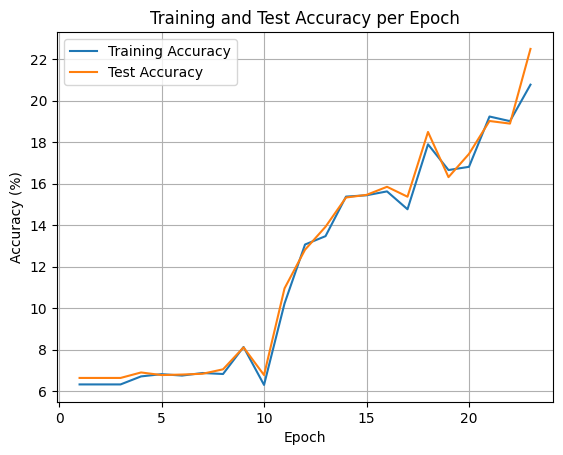

Epoch 24/100
Training Loss: 2.6336
Training Accuracy: 25.38%
Test Accuracy: 27.21%


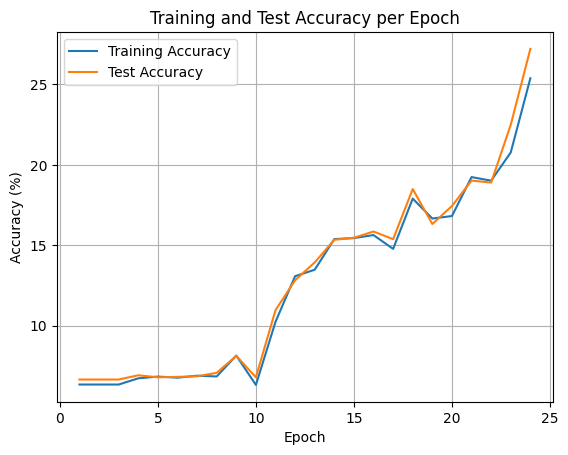

Epoch 25/100
Training Loss: 2.5285
Training Accuracy: 26.90%
Test Accuracy: 27.14%


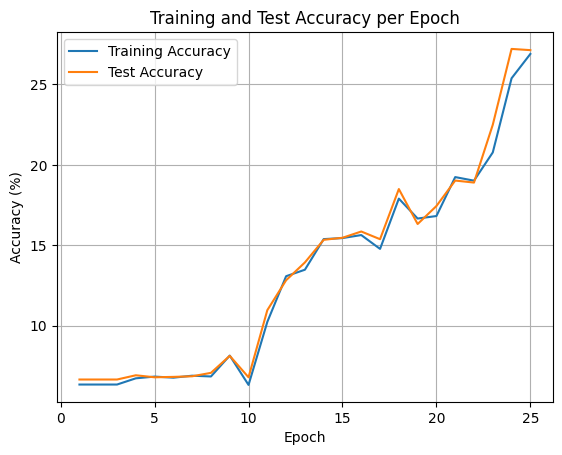

Epoch 26/100
Training Loss: 2.4336
Training Accuracy: 29.57%
Test Accuracy: 29.89%


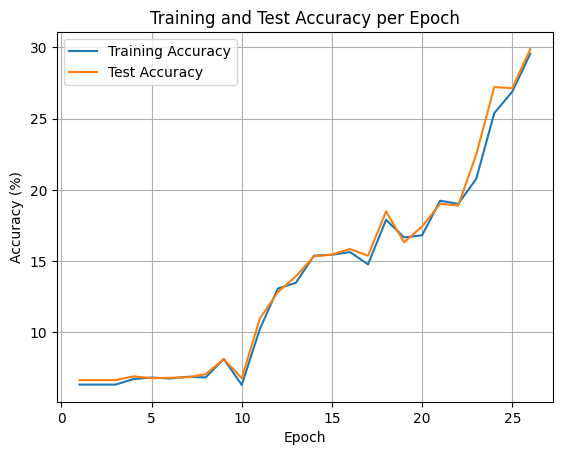

Epoch 27/100
Training Loss: 2.3165
Training Accuracy: 35.18%
Test Accuracy: 33.48%


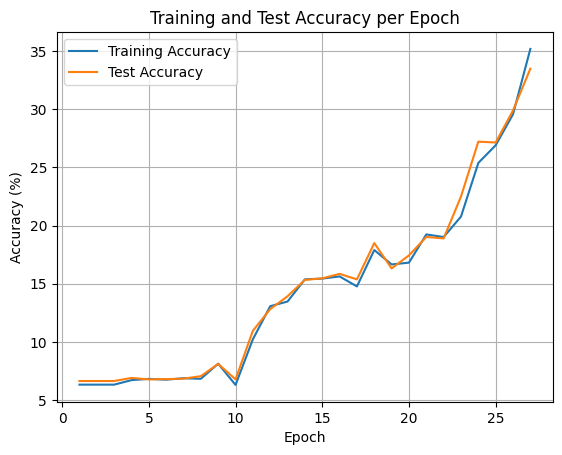

Epoch 28/100
Training Loss: 2.1880
Training Accuracy: 36.98%
Test Accuracy: 35.12%


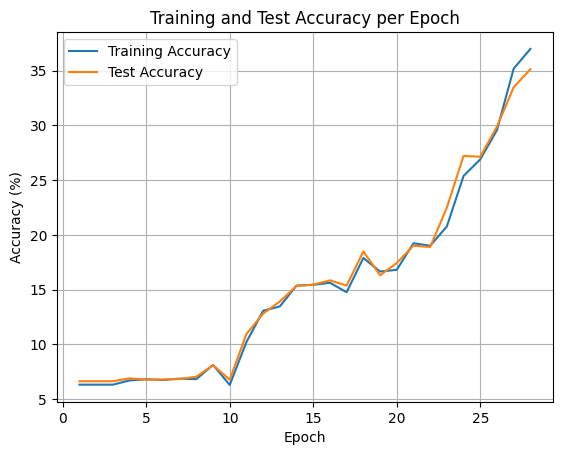

Epoch 29/100
Training Loss: 2.0347
Training Accuracy: 42.58%
Test Accuracy: 41.25%


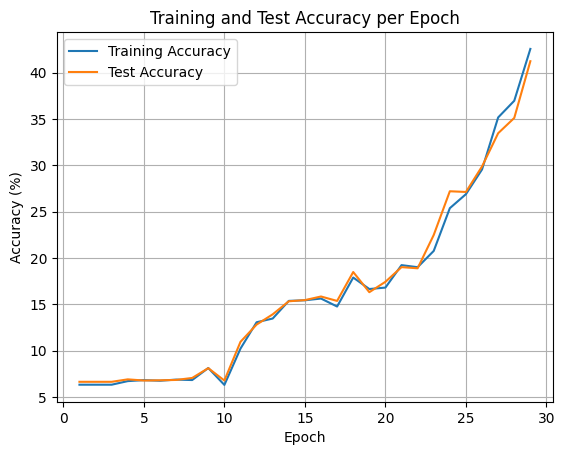

Epoch 30/100
Training Loss: 1.9012
Training Accuracy: 50.16%
Test Accuracy: 49.00%


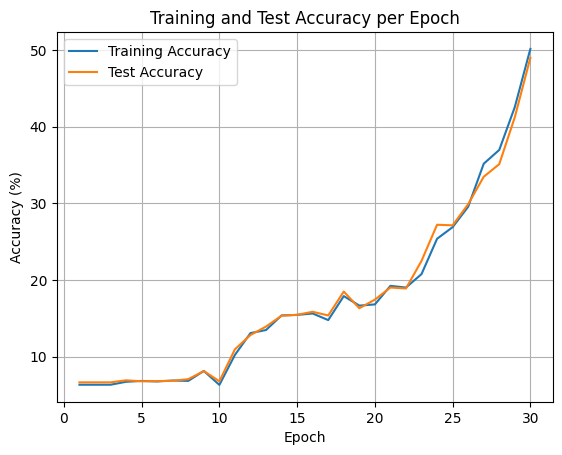

Epoch 31/100
Training Loss: 1.7599
Training Accuracy: 51.24%
Test Accuracy: 48.12%


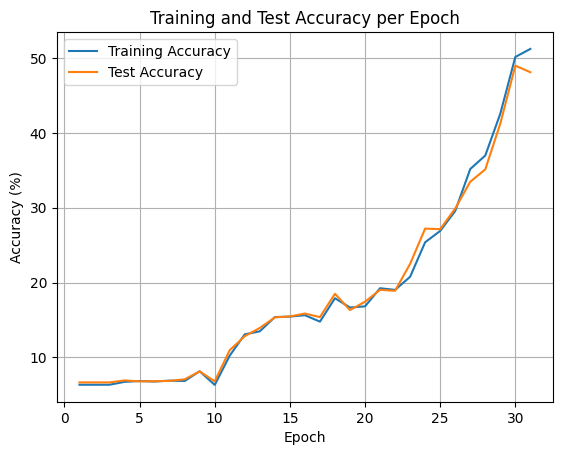

Epoch 32/100
Training Loss: 1.6302
Training Accuracy: 59.50%
Test Accuracy: 55.29%


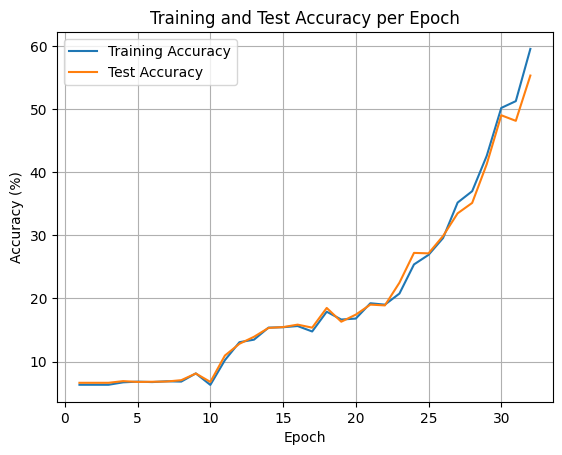

Epoch 33/100
Training Loss: 1.4867
Training Accuracy: 61.72%
Test Accuracy: 58.67%


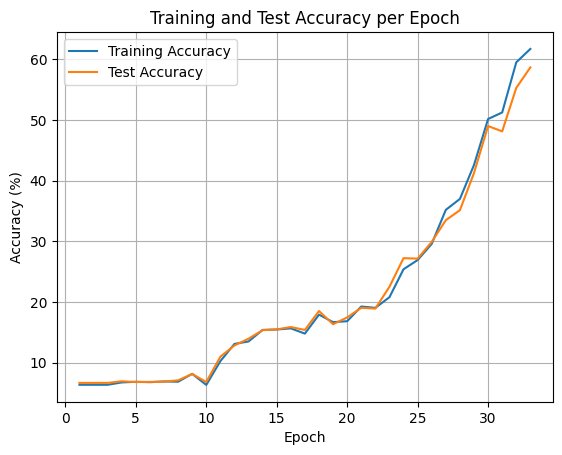

Epoch 34/100
Training Loss: 1.3179
Training Accuracy: 63.73%
Test Accuracy: 62.70%


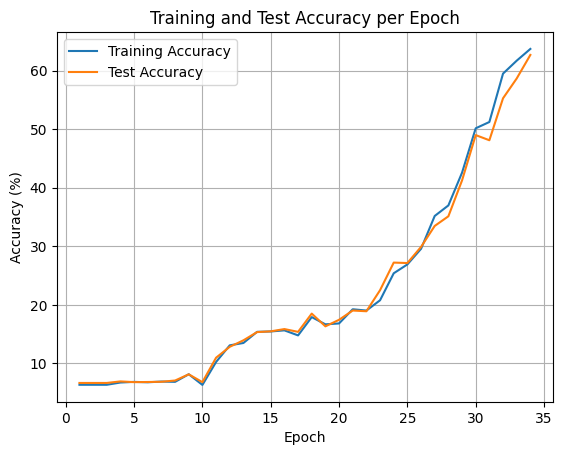

Epoch 35/100
Training Loss: 1.1515
Training Accuracy: 72.31%
Test Accuracy: 69.33%


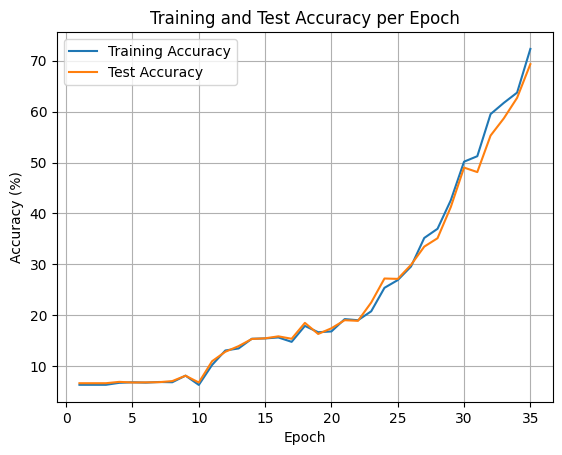

Epoch 36/100
Training Loss: 1.0099
Training Accuracy: 71.43%
Test Accuracy: 66.65%


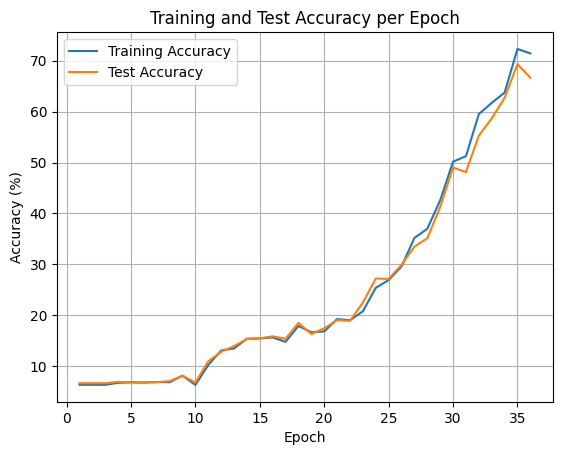

Epoch 37/100
Training Loss: 0.8767
Training Accuracy: 76.99%
Test Accuracy: 73.12%


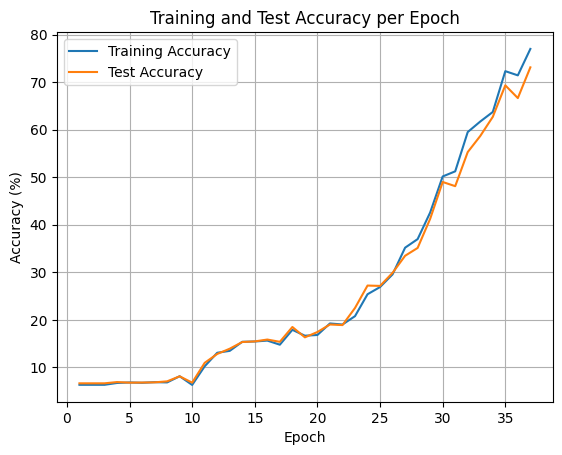

Epoch 38/100
Training Loss: 0.7636
Training Accuracy: 82.10%
Test Accuracy: 78.41%


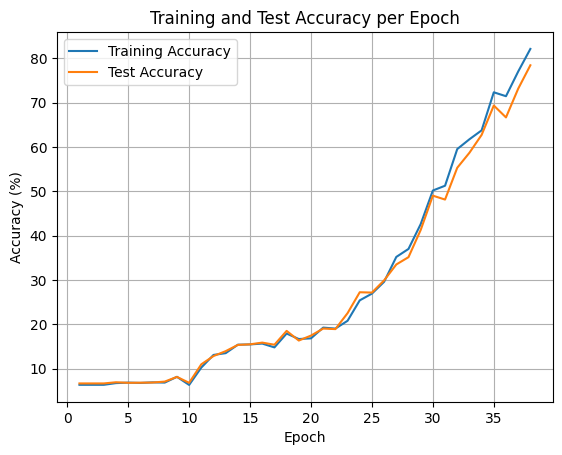

Epoch 39/100
Training Loss: 0.6724
Training Accuracy: 85.98%
Test Accuracy: 81.21%


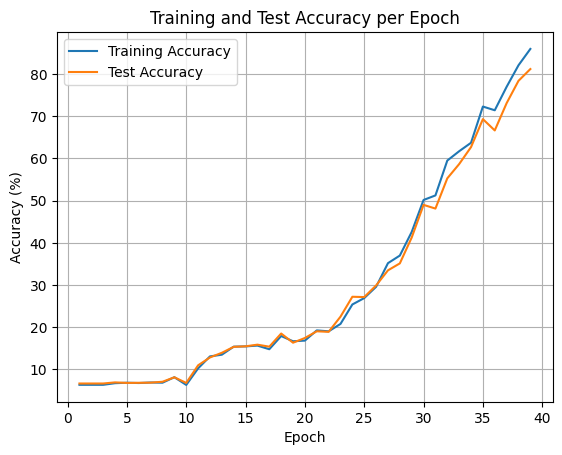

Epoch 40/100
Training Loss: 0.6004
Training Accuracy: 82.70%
Test Accuracy: 79.05%


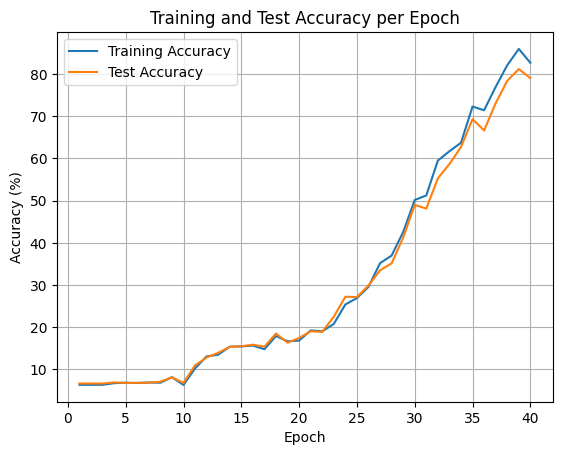

Epoch 41/100
Training Loss: 0.5241
Training Accuracy: 90.17%
Test Accuracy: 84.75%


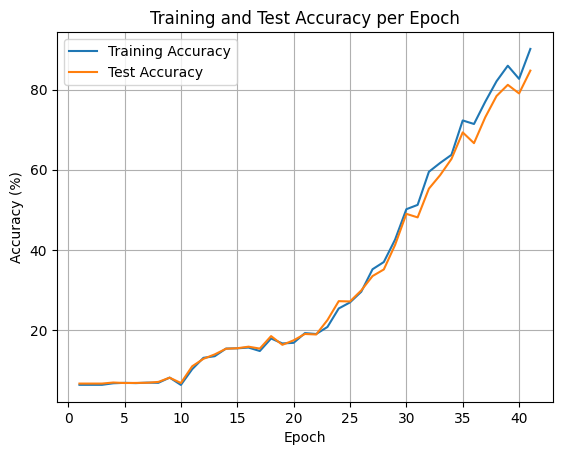

Epoch 42/100
Training Loss: 0.4773
Training Accuracy: 89.25%
Test Accuracy: 85.58%


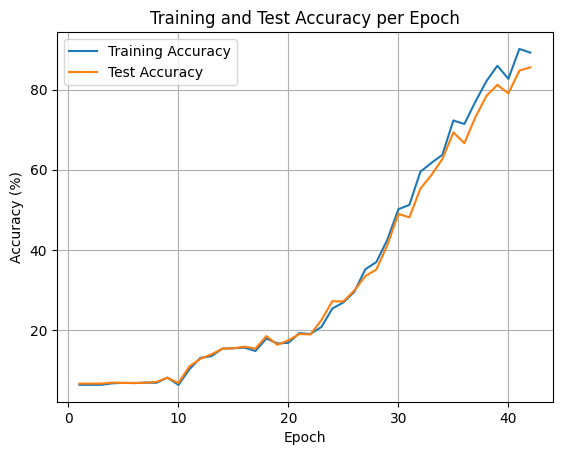

Epoch 43/100
Training Loss: 0.4303
Training Accuracy: 91.96%
Test Accuracy: 85.51%


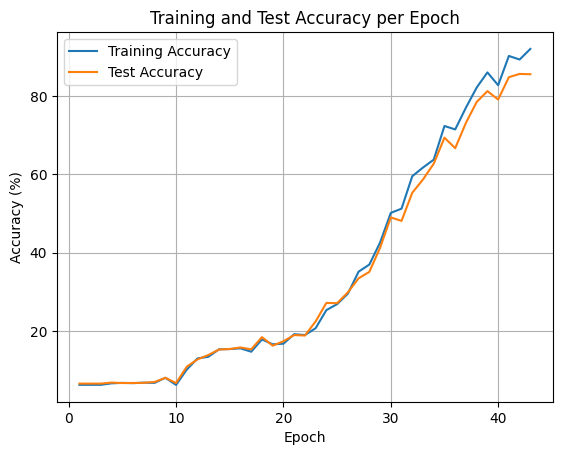

Epoch 44/100
Training Loss: 0.3805
Training Accuracy: 93.06%
Test Accuracy: 86.17%


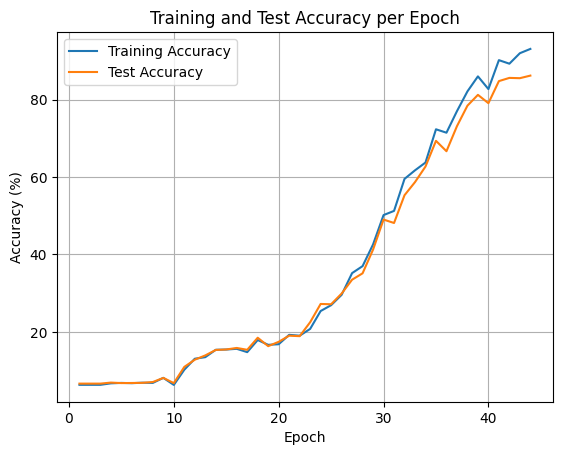

Epoch 45/100
Training Loss: 0.3399
Training Accuracy: 95.89%
Test Accuracy: 89.77%


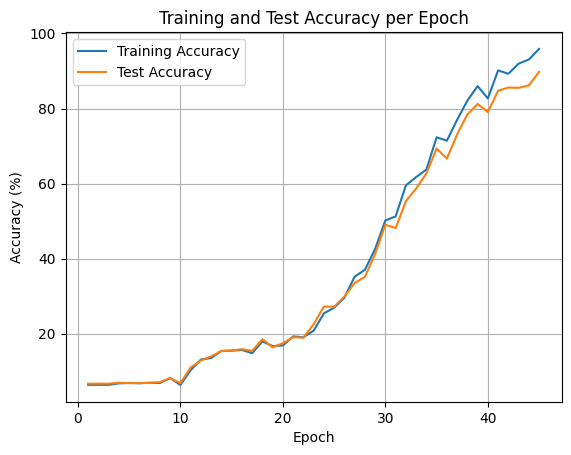

Epoch 46/100
Training Loss: 0.3077
Training Accuracy: 96.20%
Test Accuracy: 90.74%


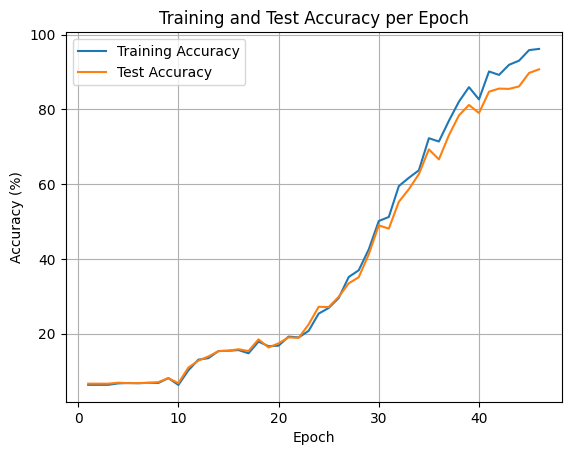

Epoch 47/100
Training Loss: 0.2812
Training Accuracy: 95.95%
Test Accuracy: 89.58%


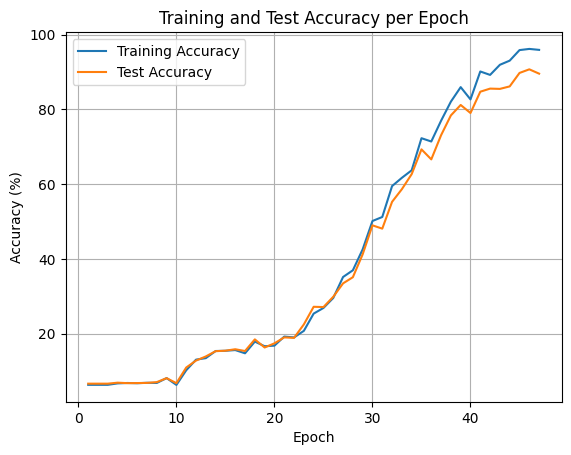

Epoch 48/100
Training Loss: 0.2552
Training Accuracy: 96.69%
Test Accuracy: 90.89%


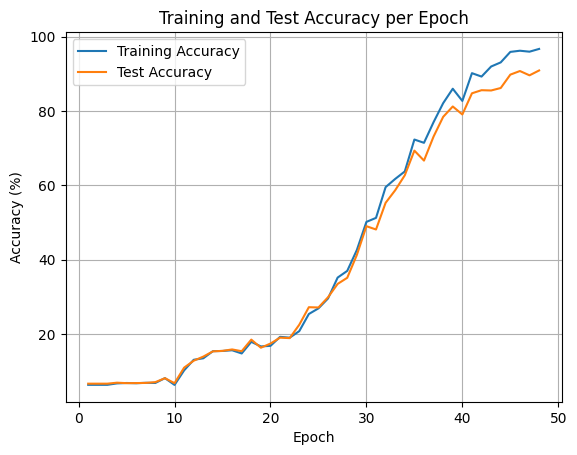

Epoch 49/100
Training Loss: 0.2373
Training Accuracy: 96.89%
Test Accuracy: 90.00%


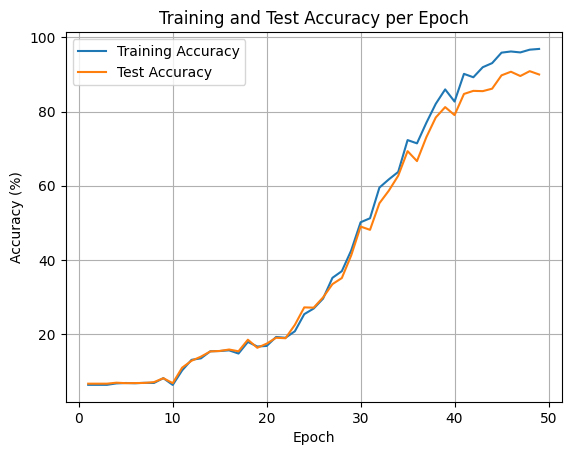

Epoch 50/100
Training Loss: 0.2078
Training Accuracy: 97.70%
Test Accuracy: 90.72%


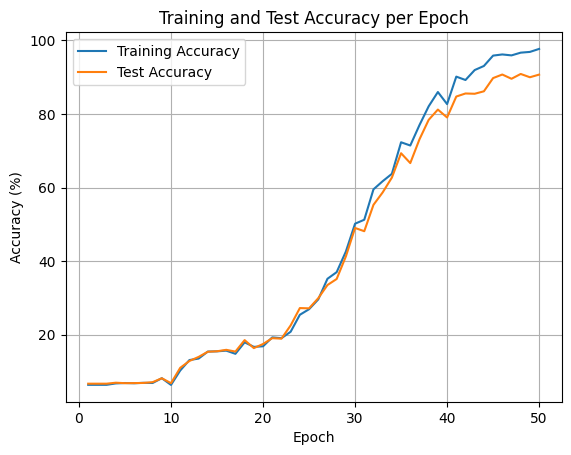

Epoch 51/100
Training Loss: 0.1914
Training Accuracy: 98.09%
Test Accuracy: 92.43%


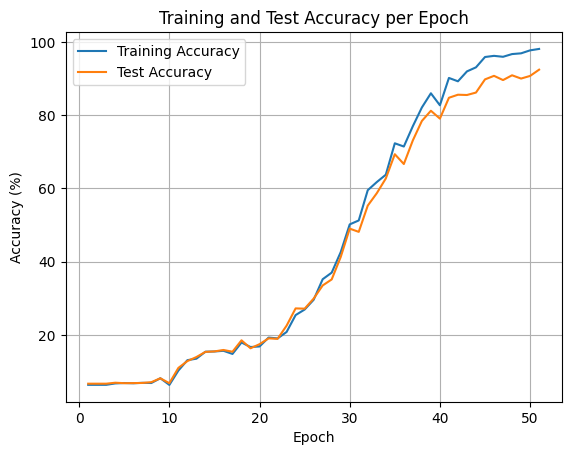

Epoch 52/100
Training Loss: 0.1789
Training Accuracy: 98.61%
Test Accuracy: 92.18%


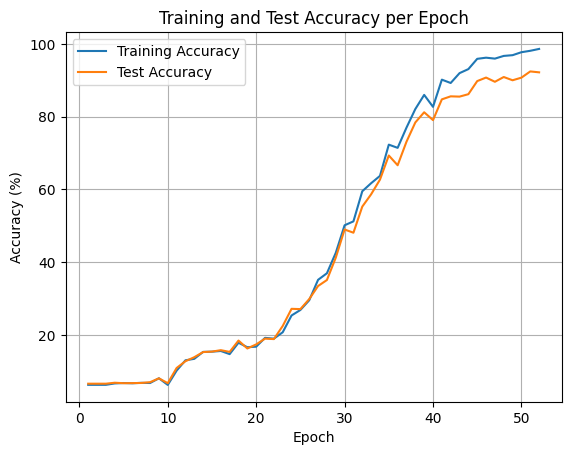

Epoch 53/100
Training Loss: 0.1572
Training Accuracy: 98.55%
Test Accuracy: 91.81%


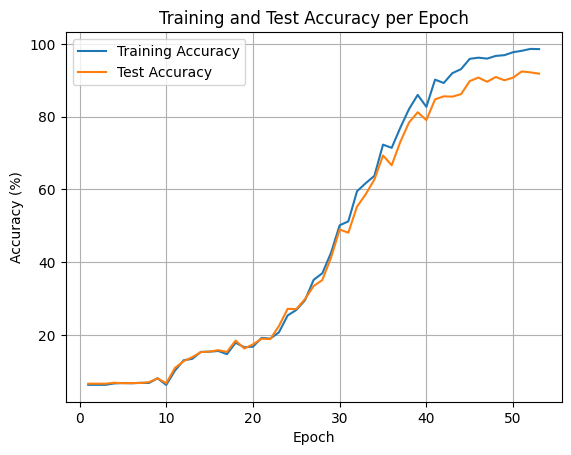

Epoch 54/100
Training Loss: 0.1558
Training Accuracy: 98.55%
Test Accuracy: 92.11%


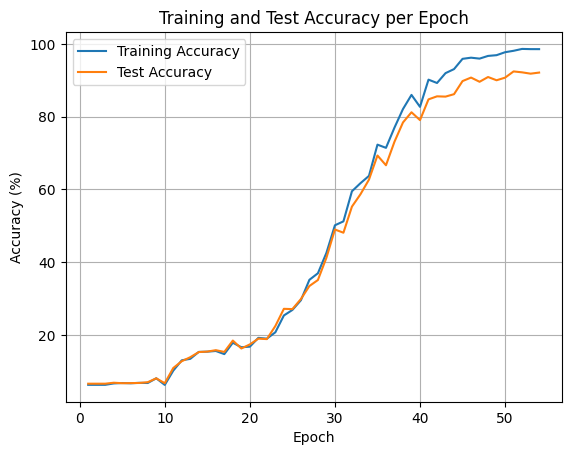

Epoch 55/100
Training Loss: 0.1396
Training Accuracy: 99.35%
Test Accuracy: 93.53%


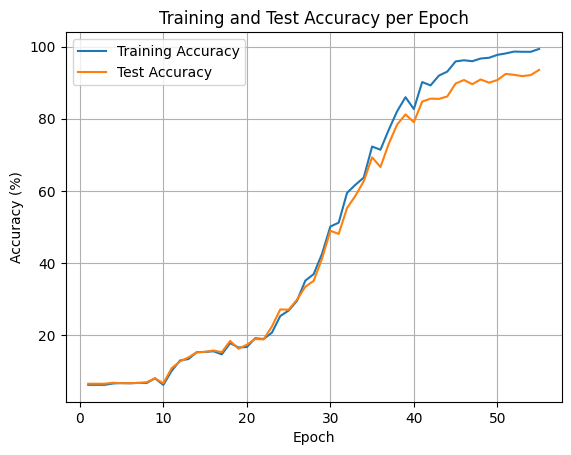

Epoch 56/100
Training Loss: 0.1304
Training Accuracy: 99.35%
Test Accuracy: 92.59%


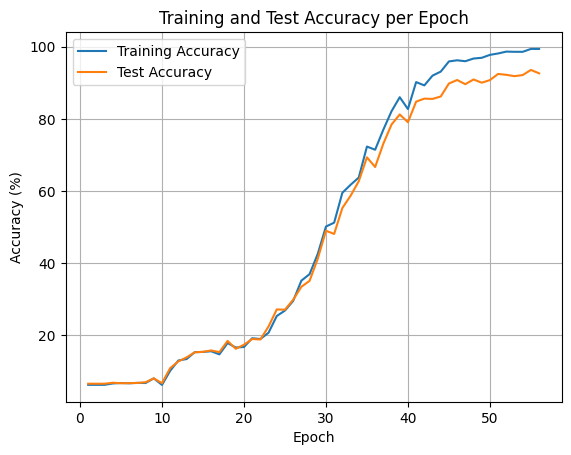

Epoch 57/100
Training Loss: 0.1196
Training Accuracy: 99.14%
Test Accuracy: 92.40%


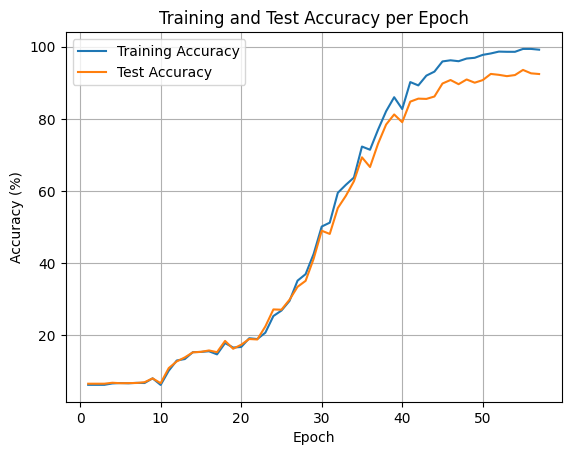

Epoch 58/100
Training Loss: 0.1100
Training Accuracy: 99.49%
Test Accuracy: 94.02%


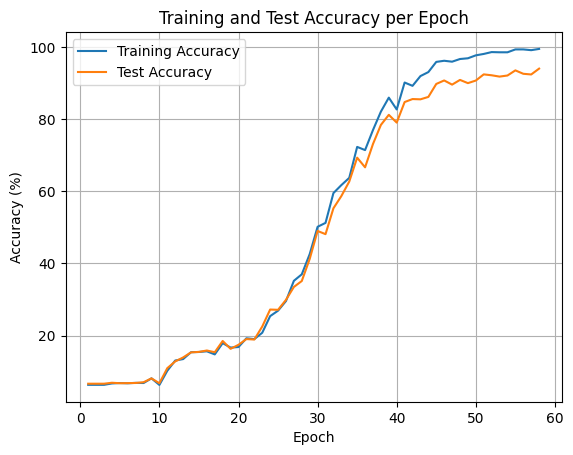

Epoch 59/100
Training Loss: 0.1052
Training Accuracy: 99.61%
Test Accuracy: 93.52%


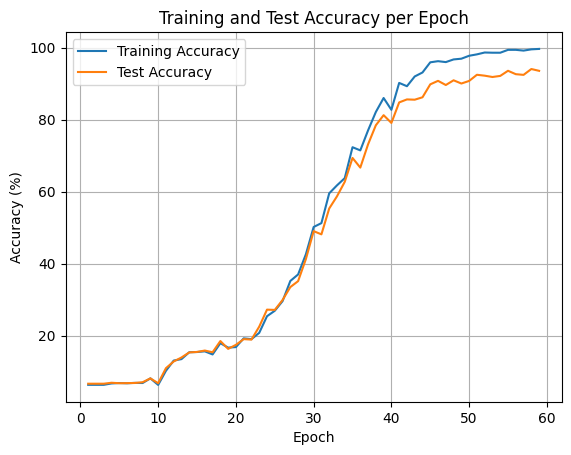

Epoch 60/100
Training Loss: 0.1032
Training Accuracy: 97.76%
Test Accuracy: 90.77%


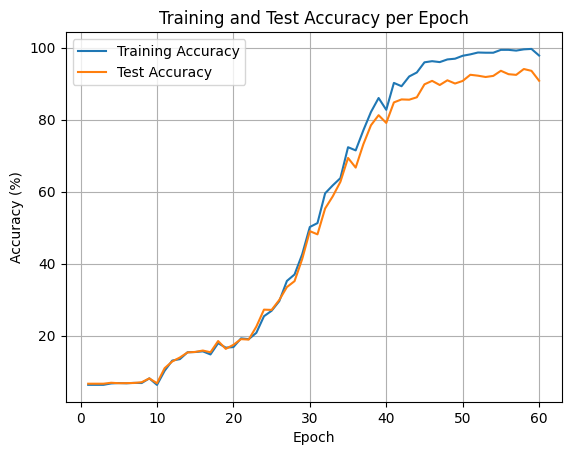

Epoch 61/100
Training Loss: 0.1010
Training Accuracy: 99.47%
Test Accuracy: 93.84%


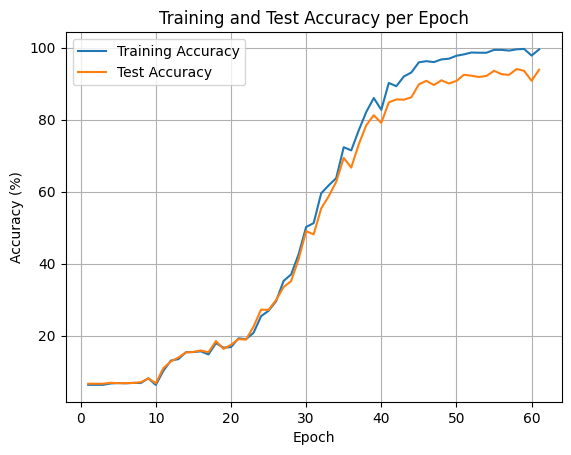

Epoch 62/100
Training Loss: 0.0907
Training Accuracy: 99.50%
Test Accuracy: 93.03%


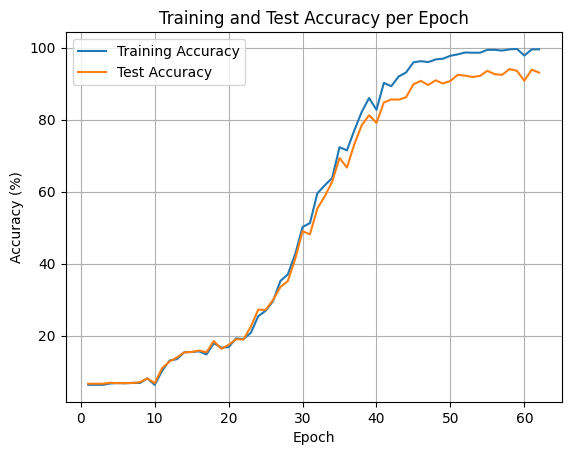

Epoch 63/100
Training Loss: 0.0886
Training Accuracy: 99.69%
Test Accuracy: 93.97%


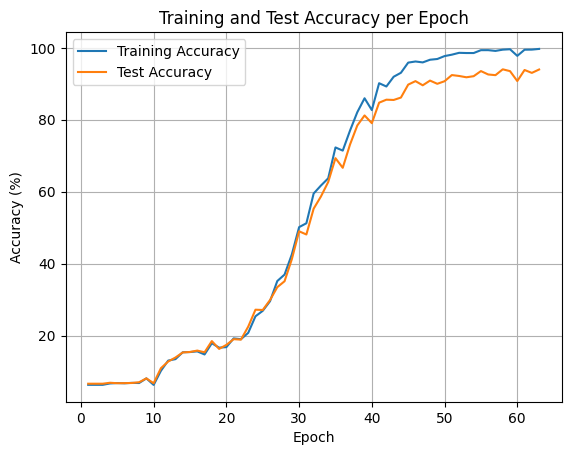

Epoch 64/100
Training Loss: 0.0839
Training Accuracy: 99.57%
Test Accuracy: 93.52%


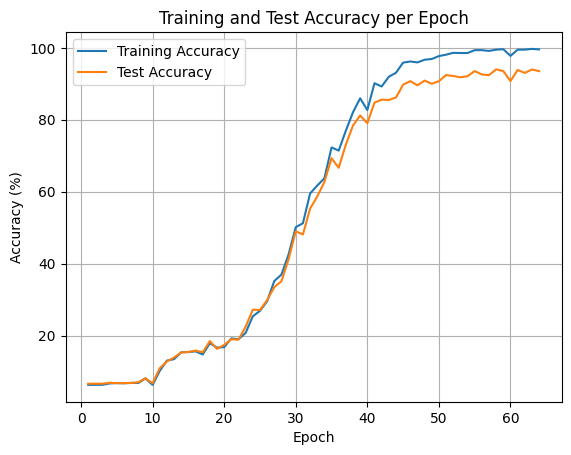

Epoch 65/100
Training Loss: 0.0782
Training Accuracy: 99.80%
Test Accuracy: 93.94%


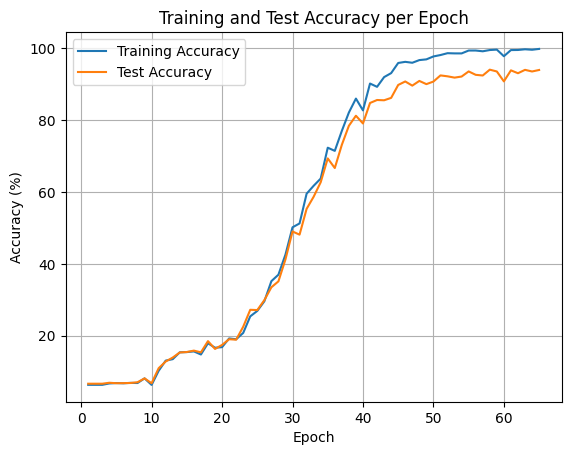

Epoch 66/100
Training Loss: 0.0774
Training Accuracy: 99.80%
Test Accuracy: 93.66%


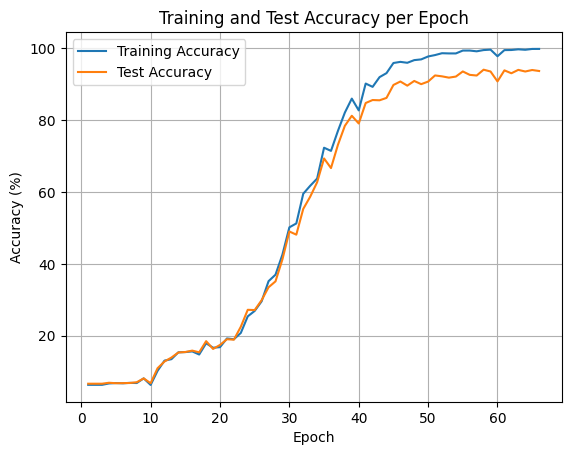

Epoch 67/100


KeyboardInterrupt: 

In [66]:

def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the maximum value in the output
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Define model, loss, and optimizer
model = CNN(num_classes).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, weight_decay=0.001)

# Initialize the ReduceLROnPlateau scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

num_epochs = 100
train_accuracies = []
test_accuracies = []
train_losses = []

# Initialize the plot
plt.figure(figsize=(10, 6))

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train()
    running_loss = 0.0  # Track the loss for the current epoch

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(images)  # Forward pass
        loss = loss_func(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        running_loss += loss.item()  # Accumulate loss

    # Calculate average loss for the current epoch
    avg_loss = running_loss / len(train_loader)

    # Accuracy on training and test data
    train_accuracy = calculate_accuracy(model, train_loader, device)
    test_accuracy = calculate_accuracy(model, test_loader, device)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_losses.append(avg_loss)

    print(f"Training Loss: {avg_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy:.2f}%")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    
    # Step the scheduler to adjust learning rate based on validation loss (or training loss)
    scheduler.step(avg_loss)

    # Clear the current plot and update with new data
    plt.clf()  # Clear the figure
    plt.plot(range(1, epoch + 2), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epoch + 2), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Test Accuracy per Epoch')
    plt.legend()
    plt.grid(True)
    
    # Display the updated plot
    plt.pause(0.1)

# Save the model's weights
torch.save(model.state_dict(), 'model/60_epochs_with_lr_scheduler.pth')

# Show the final plot after all epochs
plt.show()

### Train Code from yt 
(https://www.youtube.com/watch?v=ZBfpkepdZlw)

In [32]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
		# load in the data in batches
    for i, (images, labels) in enumerate(train_loader):  
        # move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # forward propagation
        outputs = model(images)
        loss = loss_func(outputs, labels)
        
        # backward propagation and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # at end of epoch check validation loss and acc
    with torch.no_grad():
      	# switch model to eval (not train) model
        model.eval()
        correct = 0
        total = 0
        all_val_loss = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            total += labels.size(0)
            # calculate predictions
            predicted = torch.argmax(outputs, dim=1)
            # calculate actual values
            correct += (predicted == labels).sum().item()
            # calculate the loss
            all_val_loss.append(loss_func(outputs, labels).item())
        # calculate val-loss
        mean_val_loss = sum(all_val_loss) / len(all_val_loss)
        # calculate val-accuracy
        mean_val_acc = 100 * (correct / total)
    print(
        'Epoch [{}/{}], Loss: {:.4f}, Val-loss: {:.4f}, Val-acc: {:.1f}%'.format(
            epoch+1, num_epochs, loss.item(), mean_val_loss, mean_val_acc
        )
    )

Epoch [1/50], Loss: 0.0742, Val-loss: 0.1881, Val-acc: 96.3%
Epoch [2/50], Loss: 0.0709, Val-loss: 0.2043, Val-acc: 96.1%
Epoch [3/50], Loss: 0.0595, Val-loss: 0.2188, Val-acc: 96.0%
Epoch [4/50], Loss: 0.0823, Val-loss: 0.1963, Val-acc: 96.2%
Epoch [5/50], Loss: 0.0840, Val-loss: 0.1884, Val-acc: 96.5%
Epoch [6/50], Loss: 0.0433, Val-loss: 0.1581, Val-acc: 97.1%
Epoch [7/50], Loss: 0.1143, Val-loss: 0.2037, Val-acc: 96.5%
Epoch [8/50], Loss: 0.1236, Val-loss: 0.1939, Val-acc: 96.5%
Epoch [9/50], Loss: 0.0355, Val-loss: 0.1814, Val-acc: 96.9%
Epoch [10/50], Loss: 0.0245, Val-loss: 0.1774, Val-acc: 96.9%
Epoch [11/50], Loss: 0.0163, Val-loss: 0.1809, Val-acc: 97.2%
Epoch [12/50], Loss: 0.0102, Val-loss: 0.2030, Val-acc: 96.9%
Epoch [13/50], Loss: 0.0375, Val-loss: 0.2177, Val-acc: 96.7%
Epoch [14/50], Loss: 0.0171, Val-loss: 0.1690, Val-acc: 97.1%
Epoch [15/50], Loss: 0.0659, Val-loss: 0.1488, Val-acc: 97.2%
Epoch [16/50], Loss: 0.0492, Val-loss: 0.1581, Val-acc: 97.0%
Epoch [17/50], Lo

### Test the Model

In [33]:
def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the maximum value in the output
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Determine the device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the same device
model.to(device)
# Calculate accuracy on training data
train_accuracy = calculate_accuracy(model, train_loader, device)
print(f"Accuracy on training data: {train_accuracy:.2f}%")

# Calculate accuracy on test data
test_accuracy = calculate_accuracy(model, test_loader, device)
print(f"Accuracy on test data: {test_accuracy:.2f}%")


Accuracy on training data: 100.00%
Accuracy on test data: 97.50%


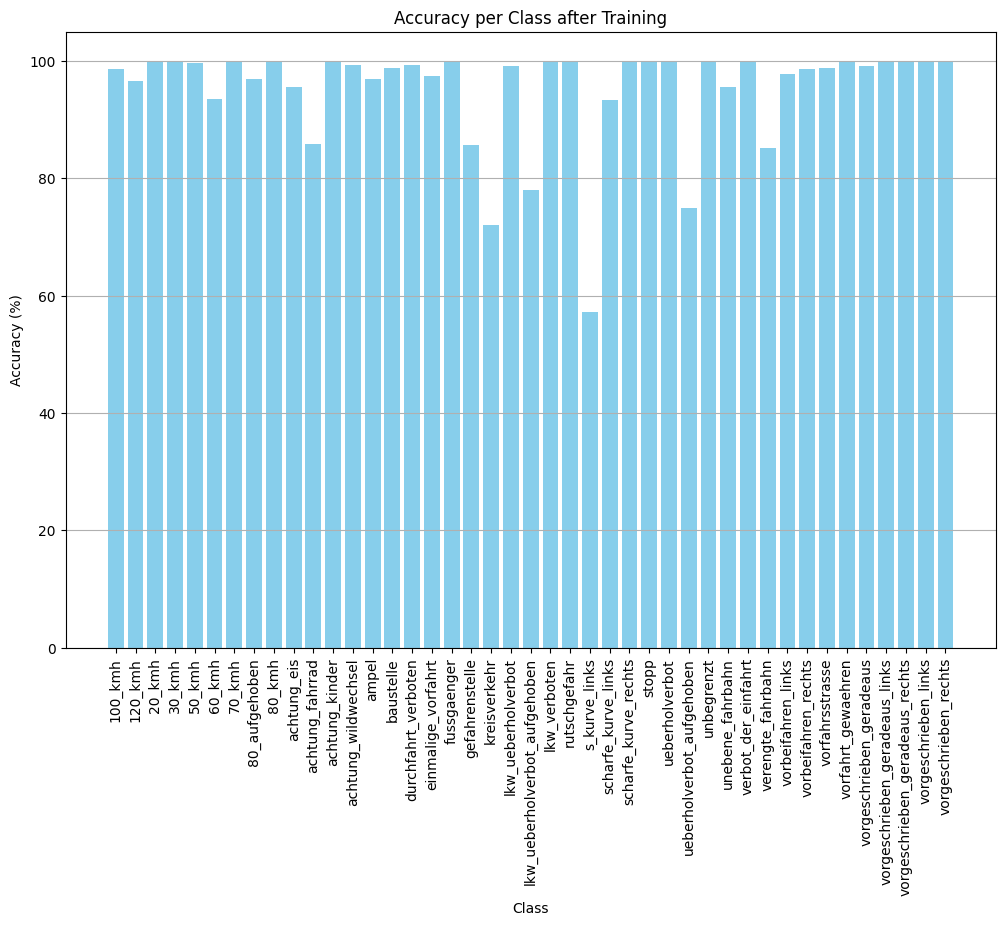

In [36]:
import torch
import matplotlib.pyplot as plt

# Berechnet die Accuracy pro Klasse, ohne die Anzahl der Klassen als Eingabe zu benötigen
def calculate_class_accuracy(model, data_loader, device):
    model.eval()
    
    # Hole die Anzahl der Klassen und die Klassennamen aus dem Dataset
    class_names = data_loader.dataset.classes
    num_classes = len(class_names)
    
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Sammle die Richtigkeit der Vorhersagen für jede Klasse
            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i] == labels[i]:
                    class_correct[label] += 1
    
    # Berechne die Accuracy für jede Klasse
    class_accuracy = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_accuracy, class_names

# Berechne und plotte die Klassenaccuracy nach den 40 Trainingsepochen
class_accuracies, class_names = calculate_class_accuracy(model, test_loader, device)

# Plot Histogramm der Klassenaccuracies mit Klassennamen auf der x-Achse
plt.figure(figsize=(12, 8))
plt.bar(range(len(class_names)), class_accuracies, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Class after Training')
plt.xticks(range(len(class_names)), class_names, rotation=90)  # Setzt die Klassennamen als x-Achsen-Beschriftungen
plt.grid(axis='y')
plt.show()


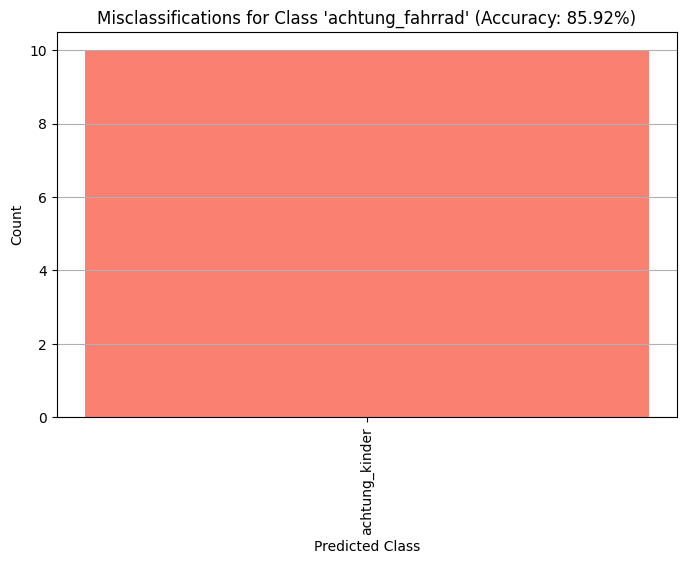

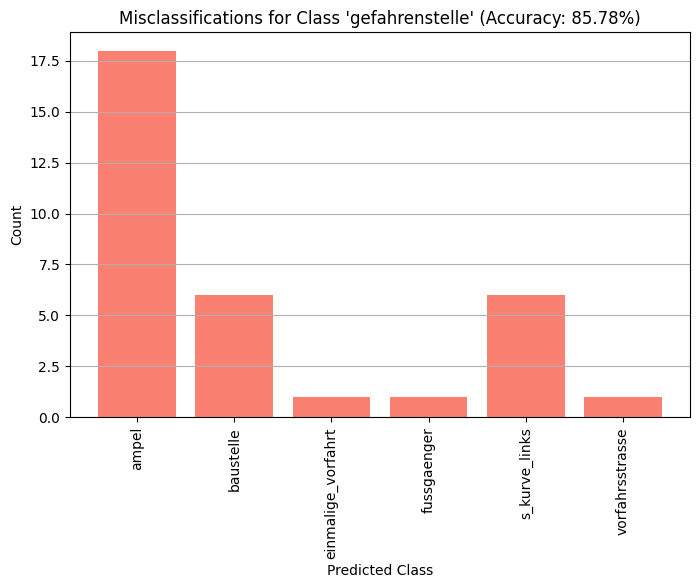

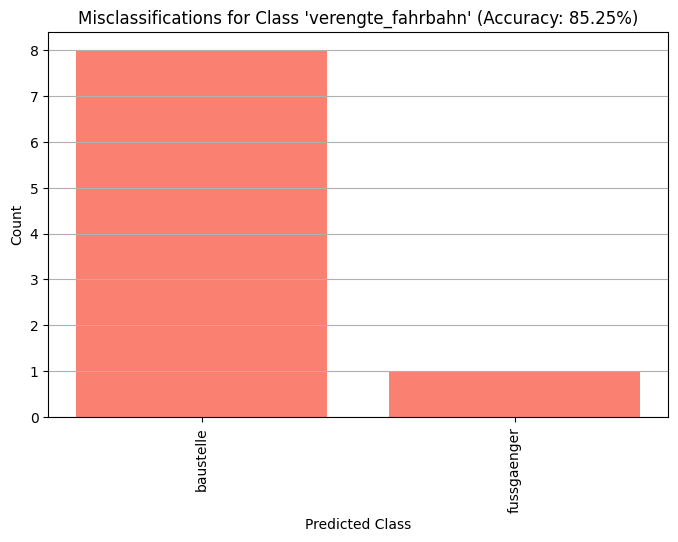

In [ ]:
import torch
import matplotlib.pyplot as plt
from collections import defaultdict

# Berechnet die Accuracy pro Klasse und speichert falsche Vorhersagen
def calculate_class_accuracy_and_misclassifications(model, data_loader, device):
    model.eval()
    
    # Hole die Anzahl der Klassen und die Klassennamen aus dem Dataset
    class_names = data_loader.dataset.classes
    num_classes = len(class_names)
    
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    misclassified_counts = defaultdict(lambda: [0] * num_classes)  # Zählt Fehlklassifizierungen je Klasse
    
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Zählt korrekte und fehlerhafte Vorhersagen
            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i] == labels[i]:
                    class_correct[label] += 1
                else:
                    misclassified_counts[label][predicted[i].item()] += 1  # Fehlklassifizierung speichern
    
    # Berechne die Accuracy für jede Klasse
    class_accuracy = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_accuracy, class_names, misclassified_counts

# Berechne Accuracy und Fehlklassifizierungen
class_accuracies, class_names, misclassified_counts = calculate_class_accuracy_and_misclassifications(model, test_loader, device)

# Erstelle Plots für Klassen mit einer Accuracy < 80%
for i, accuracy in enumerate(class_accuracies):
    if accuracy < 90:
        # Bereite Daten für die Fehlklassifizierungen dieser Klasse auf
        misclassified_counts_for_class = misclassified_counts[i]
        misclassified_class_names = [class_names[j] for j in range(len(misclassified_counts_for_class)) if misclassified_counts_for_class[j] > 0]
        misclassified_class_counts = [misclassified_counts_for_class[j] for j in range(len(misclassified_counts_for_class)) if misclassified_counts_for_class[j] > 0]
        
        # Plot der Fehlklassifizierungen für die Klasse
        plt.figure(figsize=(8, 5))
        plt.bar(misclassified_class_names, misclassified_class_counts, color='salmon')
        plt.xlabel('Predicted Class')
        plt.ylabel('Count')
        plt.title(f"Misclassifications for Class '{class_names[i]}' (Accuracy: {accuracy:.2f}%)")
        plt.xticks(rotation=90)
        plt.grid(axis='y')
        plt.show()


#### If you want to test an old model, you can do this right here

Define the CNN Model Class vor Evaluation. Make sure you replace this with the correct Conv Layers and FC Layers of your trained model. 

In [28]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=4, padding=1)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=4, padding=1)
        self.relu3 = nn.ReLU()

        self.conv_layer4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=4, padding=1)
        self.relu4 = nn.ReLU()

        self.conv_layer5 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=4, padding=1)
        self.relu5 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.dropout6 = nn.Dropout(p=0.5)
        
        
        self.fc6 = nn.Linear(128, 512) 
        self.relu6 = nn.ReLU()
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(512, 256)
        self.relu7 = nn.ReLU()

        self.dropout8 = nn.Dropout(p=0.5)
        self.fc8 = nn.Linear(256, 128)
        self.relu8 = nn.ReLU()


        self.fc9 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)

        out = self.conv_layer2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)

        out = self.conv_layer3(out)
        out = self.relu3(out)

        out = self.conv_layer4(out)
        out = self.relu4(out)

        out = self.conv_layer5(out)
        out = self.relu5(out)
        out = self.max_pool5(out)

        out = out.reshape(out.size(0), -1)
        out = self.dropout6(out)
        out = self.fc6(out)
        out = self.relu6(out)

        out = self.dropout7(out)
        out = self.fc7(out)
        out = self.relu7(out)

        out = self.dropout8(out)
        out = self.fc8(out)
        out = self.relu8(out)

        out = self.fc9(out)

        return out

Provide now informations such as path and the number of output classes

In [29]:
model_path = 'model/base_sgd_model.pth'
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Das Modell unter '{model_path}' wurde nicht gefunden.")

# Modell laden
trained_model = Net(num_classes=43)
trained_model.load_state_dict(torch.load(model_path))

C:\Users\v814u63\AppData\Local\Temp\ipykernel_24512\982607895.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

Now you can test your new model

In [31]:
def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the maximum value in the output
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Determine the device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the same device
trained_model.to(device)
# Calculate accuracy on training data
train_accuracy = calculate_accuracy(trained_model, train_loader, device)
print(f"Accuracy on training data: {train_accuracy:.2f}%")

# Calculate accuracy on test data
test_accuracy = calculate_accuracy(trained_model, test_loader, device)
print(f"Accuracy on test data: {test_accuracy:.2f}%")

Accuracy on training data: 98.35%
Accuracy on test data: 93.46%
